### DAY 7

### Oil & Gas Data Research, Web Scraping and Analysis

### Business Problem

Which countries are improving fastest in reducing flaring over time? (2012–2024)

### Datasets I Need
- Gas flaring by country (World Bank GGFR)

In [93]:
# Load the datset

import pandas as pd

df = pd.read_excel("Flare-volume-and-intensity-estimates-2012-2024.xlsx")
df.head()

,"Country, bcm",2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Russian Federation,23.866993,21.111844,19.684312,21.243893,22.653335,20.064053,21.104059,23.212170,24.128787,25.405035,25.494714,28.415779,28.84580
1,"Iran, Islamic Rep.",11.027247,11.032067,12.119681,11.998501,15.843493,17.670365,17.254740,13.810341,13.258052,17.285124,17.220775,20.421133,22.81456
2,Iraq,12.700735,13.344841,14.101867,16.310690,17.551518,17.843043,17.767136,17.914219,17.373786,17.891973,17.902880,17.689497,18.18209
3,United States,9.530318,9.209584,11.331774,11.852690,7.576103,9.516356,14.102147,17.243889,11.795555,8.763835,7.967126,9.632246,10.20477
4,"Venezuela, RB",8.151500,9.255976,9.957217,9.331920,9.268674,6.997264,8.294553,9.541420,8.588743,8.188825,8.611941,8.307149,8.31285


### Data Cleaning
- Rename the country column
- Convert from wide to long (so each row = country-year)
- Make year numeric
- Check missing values

In [96]:
df = df.rename(columns={"Country, bcm": "country"})
df.head()

,country,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Russian Federation,23.866993,21.111844,19.684312,21.243893,22.653335,20.064053,21.104059,23.212170,24.128787,25.405035,25.494714,28.415779,28.84580
1,"Iran, Islamic Rep.",11.027247,11.032067,12.119681,11.998501,15.843493,17.670365,17.254740,13.810341,13.258052,17.285124,17.220775,20.421133,22.81456
2,Iraq,12.700735,13.344841,14.101867,16.310690,17.551518,17.843043,17.767136,17.914219,17.373786,17.891973,17.902880,17.689497,18.18209
3,United States,9.530318,9.209584,11.331774,11.852690,7.576103,9.516356,14.102147,17.243889,11.795555,8.763835,7.967126,9.632246,10.20477
4,"Venezuela, RB",8.151500,9.255976,9.957217,9.331920,9.268674,6.997264,8.294553,9.541420,8.588743,8.188825,8.611941,8.307149,8.31285


In [98]:
df_long = df.melt(
    id_vars="country",
    var_name="year",
    value_name="flaring_bcm"
)

df_long.head()

,country,year,flaring_bcm
0,Russian Federation,2012,23.866993
1,"Iran, Islamic Rep.",2012,11.027247
2,Iraq,2012,12.700735
3,United States,2012,9.530318
4,"Venezuela, RB",2012,8.151500


In [100]:
df_long["year"] = pd.to_numeric(df_long["year"], errors="coerce")


In [102]:
df_long.isnull().sum()

country        13
year            0
flaring_bcm    13
dtype: int64

In [104]:
df_long = df_long.dropna(subset=["country", "flaring_bcm"]).copy()

In [106]:
df_long.isnull().sum()

country        0
year           0
flaring_bcm    0
dtype: int64

In [108]:
df_long = df_long[~df_long["country"].str.contains("Total", case=False, na=False)]

The original Excel dataset contained a blank row above the total row, which introduced missing values after reshaping the data. These non-data rows were removed by dropping records with missing country names or flaring values to ensure clean country-level time series.
And I also removed the "Total" row to avoid skewness of data

In [111]:
df_long.head()

,country,year,flaring_bcm
0,Russian Federation,2012,23.866993
1,"Iran, Islamic Rep.",2012,11.027247
2,Iraq,2012,12.700735
3,United States,2012,9.530318
4,"Venezuela, RB",2012,8.151500


### DAY 8

To Answer Business Question:

"Which countries are improving fastest in reducing flaring over time? (2012–2024)"

Before then I have to:

Build “improvement” metrics:
- Pivot back to compute endpoints
- Compute reduction metrics

In [114]:
wide = df_long.pivot(index="country", columns="year", values="flaring_bcm")

wide.head()

year,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
country,,,,,,,,,,,,,
Albania,0.000000,0.000120,0.006156,0.018834,0.021211,0.016363,0.007372,0.002380,0.000102,0.000000,0.008171,0.000292,0.00035
Algeria,7.599458,8.188072,8.698314,9.130101,8.549401,8.803133,8.718713,9.028574,9.324211,8.155820,8.614017,8.179588,7.88203
Angola,3.246723,3.162957,3.489357,4.184735,4.414241,3.800376,2.793238,2.325094,1.866345,1.801053,1.676151,1.836809,2.06090
Argentina,0.601490,0.686859,0.738438,0.647613,0.447464,0.510542,0.722755,0.941830,1.056683,1.236575,1.167578,1.092454,1.34974
Australia,0.834873,0.801921,1.137553,1.137814,0.659555,0.655919,0.874477,1.370889,0.977224,0.813098,0.704658,0.663041,0.61797


In [116]:
wide["flaring_2012"] = wide[2012]
wide["flaring_2024"] = wide[2024]

wide["abs_change_bcm"] = wide["flaring_2024"] - wide["flaring_2012"]
wide["pct_change_%"] = (wide["flaring_2024"] / wide["flaring_2012"] - 1) * 100

# CAGR over 12 years (2012 → 2024)
wide["cagr_%"] = ((wide["flaring_2024"] / wide["flaring_2012"]) ** (1/11) - 1) * 100

Make a realistic ranking (avoid tiny base effect)

Some countries flare very little in 2012, so they can look like “best reducers” just because they started near zero.

So we filter to countries with meaningful flaring in 2012, for example ≥ 1 bcm:

In [119]:
rank = wide.reset_index()

rank_filtered = rank[rank["flaring_2012"] >= 1].copy()

# Sort by fastest reduction (most negative CAGR)
rank_filtered = rank_filtered.sort_values("cagr_%")

rank_filtered[["country","flaring_2012","flaring_2024","abs_change_bcm","pct_change_%","cagr_%"]].head(10)

year,country,flaring_2012,flaring_2024,abs_change_bcm,pct_change_%,cagr_%
94,Uzbekistan,1.827650,0.44125,-1.386400,-75.856979,-12.119980
50,Kazakhstan,3.959199,1.16328,-2.795919,-70.618297,-10.537020
97,Yemen,1.110352,0.37423,-0.736122,-66.296262,-9.413883
92,United Kingdom,1.296459,0.54691,-0.749549,-57.815103,-7.546499
42,Indonesia,3.536877,1.70288,-1.833997,-51.853571,-6.428802
51,Kuwait,1.131930,0.60595,-0.525980,-46.467552,-5.522405
89,Turkmenistan,2.448511,1.34481,-1.103701,-45.076427,-5.301804
12,Brazil,1.594801,0.95373,-0.641071,-40.197567,-4.566310
29,"Egypt, Arab Rep.",2.667651,1.62707,-1.040581,-39.007378,-4.395187
2,Angola,3.246723,2.06090,-1.185823,-36.523694,-4.047653


Interpretation:

- abs_change_bcm: negative = reduced flaring (good)

- pct_change_%: more negative = better

- cagr_%: more negative = fastest yearly reduction (best metric for “improving fastest”)

#### Top 10 fastest reducers (CAGR)

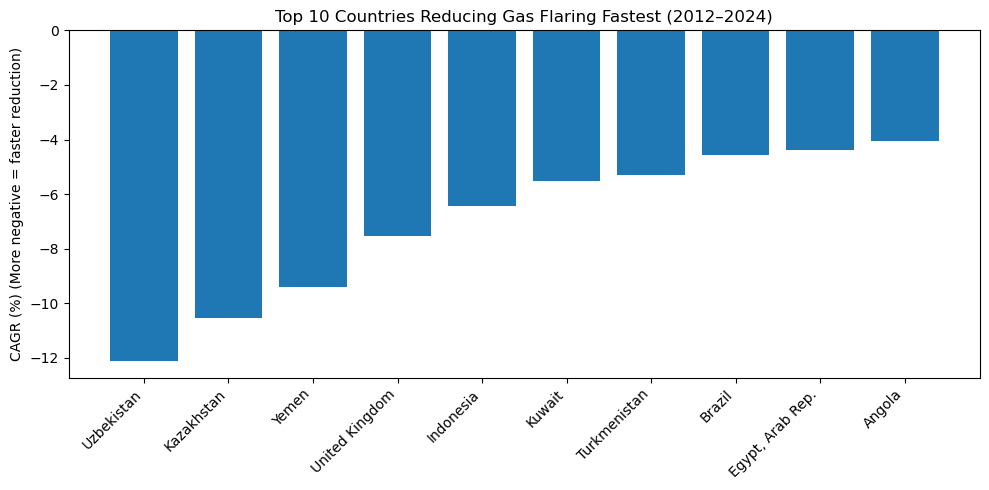

In [123]:
import matplotlib.pyplot as plt

top10 = rank_filtered.head(10)

plt.figure(figsize=(10,5))
plt.bar(top10["country"], top10["cagr_%"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("CAGR (%) (More negative = faster reduction)")
plt.title("Top 10 Countries Reducing Gas Flaring Fastest (2012–2024)")
plt.tight_layout()
plt.show()

#### Fastest reducers (CAGR)
- **Uzbekistan is the fastest improver (most negative CAGR, ~-12%/yr)**. This means it reduced flaring at the quickest average annual rate over the period.

- **Kazakhstan and Yemen also show very strong improvement rates (around -10% and -9% per year)**, meaning their flaring levels fell rapidly relative to where they started.

- **Countries like United Kingdom and Indonesia appear high on this list** even though they may not be the biggest flarers globally—because this ranking is about rate of reduction, not total volume.

- **The later entries (Brazil, Egypt, Angola) are still improving**, but at a slower yearly pace (around -4%/yr). They are reducing flaring, just not as aggressively as the top countries.

Fastest improvement is concentrated in countries that achieved sustained year-on-year reductions, indicating strong operational upgrades, enforcement, or gas utilization investments.

#### Top 10 biggest reductions (absolute volume)

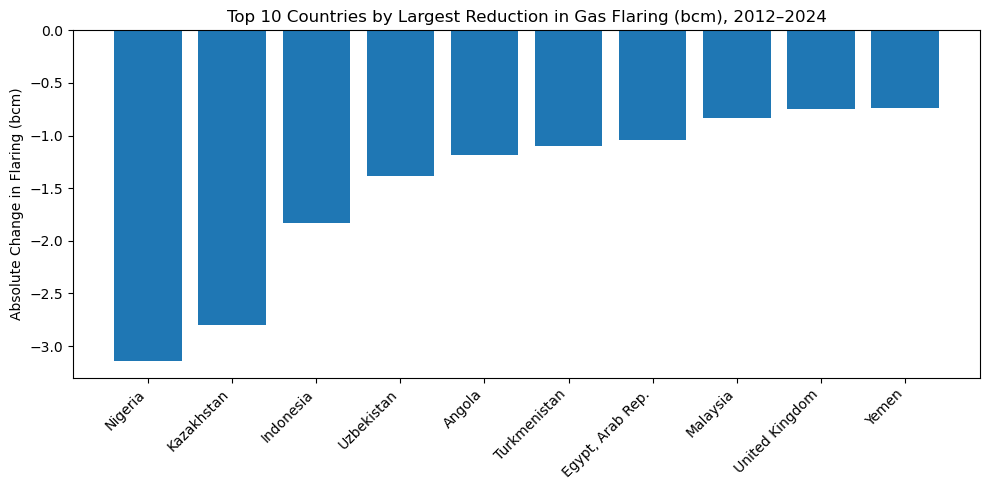

In [127]:
top10_abs = rank_filtered.sort_values("abs_change_bcm").head(10)

plt.figure(figsize=(10,5))
plt.bar(top10_abs["country"], top10_abs["abs_change_bcm"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Absolute Change in Flaring (bcm)")
plt.title("Top 10 Countries by Largest Reduction in Gas Flaring (bcm), 2012–2024")
plt.tight_layout()
plt.show()

#### Largest absolute reductions (bcm)

- **Nigeria shows the largest absolute reduction in flaring volume (biggest drop in bcm)**. This means Nigeria delivered the most “real-world” reduction in total gas flared among the top reducers.

- **Kazakhstan and Indonesia also reduced large volumes**, suggesting that improvements occurred in countries with historically significant flaring.

**This chart highlights impact at scale: countries can reduce a lot of flaring volume even if their percentage reduction is not the fastest.**

- **Some countries (e.g., United Kingdom, Yemen)** appear here with smaller absolute reductions—showing that they improved, but their total flaring volumes were lower compared to major flaring countries.

Absolute reductions identify where the largest emissions and waste savings occurred, which is more relevant for global impact than growth-rate rankings.

In [130]:
rank_filtered[["country","flaring_2012","flaring_2024","pct_change_%","cagr_%"]].head(10)

year,country,flaring_2012,flaring_2024,pct_change_%,cagr_%
94,Uzbekistan,1.827650,0.44125,-75.856979,-12.119980
50,Kazakhstan,3.959199,1.16328,-70.618297,-10.537020
97,Yemen,1.110352,0.37423,-66.296262,-9.413883
92,United Kingdom,1.296459,0.54691,-57.815103,-7.546499
42,Indonesia,3.536877,1.70288,-51.853571,-6.428802
51,Kuwait,1.131930,0.60595,-46.467552,-5.522405
89,Turkmenistan,2.448511,1.34481,-45.076427,-5.301804
12,Brazil,1.594801,0.95373,-40.197567,-4.566310
29,"Egypt, Arab Rep.",2.667651,1.62707,-39.007378,-4.395187
2,Angola,3.246723,2.06090,-36.523694,-4.047653


**Uzbekistan and Kazakhstan** lead in the speed of improvement, while Nigeria and Kazakhstan lead in total volume reduced, showing that the fastest improvers are not always the largest contributors by volume.

In [133]:
largest_abs = rank_filtered.sort_values("abs_change_bcm").head(10)

largest_abs[["country","flaring_2012","flaring_2024","abs_change_bcm","pct_change_%","cagr_%"]]

year,country,flaring_2012,flaring_2024,abs_change_bcm,pct_change_%,cagr_%
62,Nigeria,9.622373,6.47956,-3.142813,-32.661520,-3.531045
50,Kazakhstan,3.959199,1.16328,-2.795919,-70.618297,-10.537020
42,Indonesia,3.536877,1.70288,-1.833997,-51.853571,-6.428802
94,Uzbekistan,1.827650,0.44125,-1.386400,-75.856979,-12.119980
2,Angola,3.246723,2.06090,-1.185823,-36.523694,-4.047653
89,Turkmenistan,2.448511,1.34481,-1.103701,-45.076427,-5.301804
29,"Egypt, Arab Rep.",2.667651,1.62707,-1.040581,-39.007378,-4.395187
53,Malaysia,2.363553,1.53146,-0.832093,-35.205177,-3.868150
92,United Kingdom,1.296459,0.54691,-0.749549,-57.815103,-7.546499
97,Yemen,1.110352,0.37423,-0.736122,-66.296262,-9.413883


In [135]:
df_long.to_csv("gas_flaring_country_year_2012_2024.csv", index=False)
rank_filtered.to_csv("gas_flaring_fastest_reducers_2012_2024.csv", index=False)
largest_abs.to_csv("gas_flaring_largest_reduction_2012_2024.csv", index=False)
